In [1]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms

os.chdir(os.path.join(os.getcwd(), '..'))

from data import PollenDataset

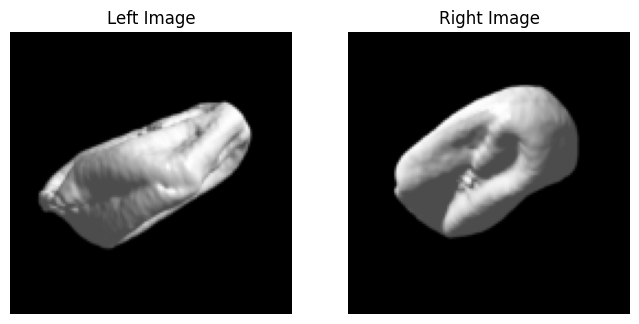

In [2]:
image_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

dataset = PollenDataset(image_transforms=image_transforms)

(left_img, right_img), points, rotation, name = dataset[0]

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(left_img.permute(1,2,0), cmap='gray')
plt.title("Left Image")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(right_img.permute(1,2,0), cmap='gray')
plt.title("Right Image")
plt.axis("off")
plt.show()

In [3]:
(sample_images, points, rotation, name) = dataset[0]
front_tensor, side_tensor = sample_images  # Assume left = front view, right = side view

In [4]:
name

'/Users/nils/Documents/Classes/bat/sequoia/data/processed/meshes/21532_Blue_sedge_Carex_flacca_pollen_grain_shrunken.stl'

In [5]:
# Convert tensors to numpy arrays (images are 1024x1024)
front_np = front_tensor.squeeze(0).numpy()
side_np = side_tensor.squeeze(0).numpy()

# Create binary masks: any nonzero pixel is considered part of the object.
front_bin = (front_np > 0).astype(np.uint8)
side_bin = (side_np > 0).astype(np.uint8)

# Define the volume dimensions (cubic volume, size from image dimensions)
H, W = front_bin.shape  # (1024, 1024)
D = W  # depth = width, i.e., 1024

# Extrude the front silhouette along the z-axis.
front_vol = np.repeat(front_bin[:, :, np.newaxis], D, axis=2)

# Extrude the side silhouette along the x-axis.
# The side view corresponds to (z, y); insert an axis for x and repeat.
side_vol = np.repeat(side_bin[:, np.newaxis, :], W, axis=1)

# Compute the visual hull as the voxel-wise intersection.
visual_hull = np.logical_and(front_vol, side_vol)

# Downsample the volume for faster visualization if necessary.
# For instance, reduce by a factor of 8 (adjust step as needed).
step = 1
voxel_data = visual_hull[::step, ::step, ::step]

### 1. Load sample data and compute the reconstruction (visual hull)

In [6]:
front_bin = (front_np > 0).astype(np.uint8)
side_bin = (side_np > 0).astype(np.uint8)

# Define volume dimensions – we assume a cubic volume.
H, W = front_bin.shape  # should be 1024 x 1024
D = W  # depth equal to width

# Extrude the front silhouette along the z-axis:
front_vol = np.repeat(front_bin[:, :, np.newaxis], D, axis=2)

# Extrude the side silhouette along the x-axis:
side_vol = np.repeat(side_bin[:, np.newaxis, :], W, axis=1)

# Compute the voxel-wise intersection (Visual Hull):
recon_volume = np.logical_and(front_vol, side_vol)
print("Reconstruction voxel volume shape:", recon_volume.shape)


Reconstruction voxel volume shape: (128, 128, 128)


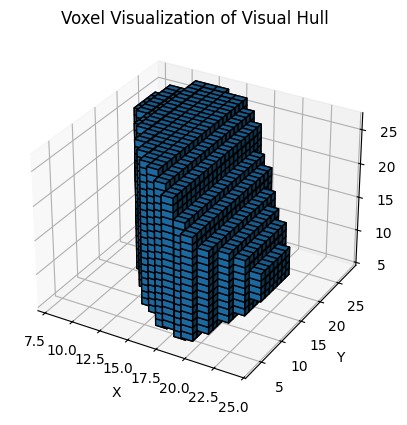

In [7]:
# simplify the voxels
step = 4
simplified_recon_volume = recon_volume[::step, ::step, ::step]

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(simplified_recon_volume, edgecolor='k')
ax.set_title("Voxel Visualization of Visual Hull")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

In [8]:
import trimesh
import numpy as np
import scipy

mesh = trimesh.Trimesh(vertices=vertices, faces=faces)

# Get the axis-aligned bounding box of the mesh
bbox_min, bbox_max = mesh.bounds
extent = bbox_max - bbox_min

# Compute the voxel pitch based on the largest dimension for a rough 128 scale
pitch = np.max(extent) / 128.0

# Fast voxelization with trimesh (this step is optimized)
voxels = mesh.voxelized(pitch)
voxel_grid = voxels.matrix.astype(np.float32)  # binary occupancy

# Resample voxel grid to exactly 128x128x128
current_shape = voxel_grid.shape
scale_factors = [128 / s for s in current_shape]
voxel_grid_128 = scipy.ndimage.zoom(voxel_grid, zoom=scale_factors, order=0)  # nearest-neighbor

print(voxel_grid_128.shape)  # Should print (128, 128, 128)

NameError: name 'vertices' is not defined

In [7]:
# simplify the voxels
step = 4
gt_simplified_volume = voxel_grid_128[::step, ::step, ::step]

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(gt_simplified_volume, edgecolor='k')
ax.set_title("Voxel Visualization of Visual Hull")
ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
plt.show()

NameError: name 'voxel_grid_128' is not defined

In [8]:
from scipy.ndimage import rotate

def iou3d(vol1, vol2):
    intersection = np.logical_and(vol1, vol2)
    union = np.logical_or(vol1, vol2)
    return np.sum(intersection) / np.sum(union)

def rotate_voxel_grid(voxel_grid, angle_x=0, angle_y=0, angle_z=0):
    """
    Rotate a 3D voxel occupancy grid about the x, y, and z axes.
    
    Parameters:
    - voxel_grid: 3D numpy array of booleans where True indicates an occupied voxel.
    - angle_x: Rotation angle (in degrees) around the x-axis (applied in the (y, z) plane).
    - angle_y: Rotation angle (in degrees) around the y-axis (applied in the (x, z) plane).
    - angle_z: Rotation angle (in degrees) around the z-axis (applied in the (x, y) plane).
    
    Returns:
    - A new 3D numpy array representing the rotated voxel grid.
    """
    # Rotate around the x-axis (rotate in the (y, z) plane)
    rotated = rotate(voxel_grid, angle=angle_x, axes=(1, 2),
                     reshape=True, order=0, mode='constant', cval=False)
    # Rotate around the y-axis (rotate in the (x, z) plane)
    rotated = rotate(rotated, angle=angle_y, axes=(0, 2),
                     reshape=True, order=0, mode='constant', cval=False)
    # Rotate around the z-axis (rotate in the (x, y) plane)
    rotated = rotate(rotated, angle=angle_z, axes=(0, 1),
                     reshape=True, order=0, mode='constant', cval=False)
    
    return rotated

recon_volume_rotated = rotate_voxel_grid(recon_volume, -rotation[0], -rotation[1], -rotation[2])

iou = iou3d(recon_volume, voxel_grid_128)
print("IoU between visual hull and voxelized mesh:", iou)

NameError: name 'recon_volume' is not defined

In [9]:
# simplify the recon_volume_rotated
step = 4
recon_volume_rotated_simplified = recon_volume_rotated[::step, ::step, ::step]

# plot both the regular recon_volume and the rotatd recon_volume
fig, axes = plt.subplots(1, 3, figsize=(12, 6))
axes[0] = fig.add_subplot(131, projection='3d')
axes[0].voxels(simplified_recon_volume, edgecolor='k')
axes[0].set_title("Visual Hull")
axes[0].set_xlabel("X")
axes[0].set_ylabel("Y")
axes[0].set_zlabel("Z")

axes[1] = fig.add_subplot(132, projection='3d')
axes[1].voxels(recon_volume_rotated_simplified, edgecolor='k')
axes[1].set_title("Visual Hull Rotated")
axes[1].set_xlabel("X")
axes[1].set_ylabel("Y")
axes[1].set_zlabel("Z")

axes[2] = fig.add_subplot(133, projection='3d')
axes[2].voxels(gt_simplified_volume, edgecolor='k')
axes[2].set_title("Ground Truth")
axes[2].set_xlabel("X")
axes[2].set_ylabel("Y")
axes[2].set_zlabel("Z")

plt.show()

NameError: name 'recon_volume_rotated' is not defined

TODO: Normalized Surface Distance?

In [40]:
# models/visual_hull.py
import torch
import numpy as np
import lightning.pytorch as pl

class VisualHull(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.dummy_param = torch.nn.Parameter(torch.zeros(1))
        
    def forward(self, front_tensor: torch.Tensor, side_tensor: torch.Tensor, step: int = 1) -> np.ndarray:
        front_np = front_tensor.squeeze().detach().cpu().numpy()
        side_np = side_tensor.squeeze().detach().cpu().numpy()
    
        front_bin = (front_np > 0).astype(np.uint8)
        side_bin = (side_np > 0).astype(np.uint8)
        
        print(front_bin.shape)
        
        H, W = front_bin.shape
        D = W

        front_vol = np.repeat(front_bin[:, :, np.newaxis], D, axis=2)
        side_vol = np.repeat(side_bin[:, np.newaxis, :], W, axis=1)
        visual_hull = np.logical_and(front_vol, side_vol)
        voxel_data = visual_hull[::step, ::step, ::step]
        
        return voxel_data

    def training_step(self, batch, batch_idx):
        (left_image, right_image), _, rotations, _ = batch
        _ = self.forward(left_image, right_image)
        loss = self.dummy_param * 0.0
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        (left_image, right_image), _, rotations, _ = batch
        voxel_data = self.forward(left_image, right_image)
        # For instance, log the voxel count as an evaluation metric.
        voxel_count = float(voxel_data.sum())
        self.log("val_voxel_count", voxel_count, prog_bar=True)
        loss = self.dummy_param * 0.0
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [41]:
vh = VisualHull()

(left, right), points, rotation, name = dataset[0]

vh(left.unsqueeze(0), right.unsqueeze(0))

(128, 128)


array([[[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]],

       [[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, Fal

In [16]:
import trimesh

mesh = trimesh.load(os.path.join('data', 'processed', 'meshes', name))

In [17]:
voxel = mesh.voxelized(pitch=1)

In [18]:
voxel.show()

In [15]:
largest_shape = (0,0,0)
name = None

for idx in range(len(dataset)):
    _, _, _, name = dataset[idx]

    mesh = trimesh.load(os.path.join('data', 'processed', 'meshes', name))
    
    vox = mesh.voxelized(pitch=1.0)

    if vox.matrix.shape > largest_shape:
        largest_shape = vox.matrix.shape
        name = name

print(largest_shape)


(191, 144, 47)


In [20]:

_, _, _, test_name = dataset[len(dataset)-1]

In [27]:
test_mesh = trimesh.load(os.path.join("data", "raw", test_name.split('/')[-1]))

In [28]:
test_mesh.is_watertight

True